In [1]:
LOGS_FOLDER = '/home/jeyseb/MP/CooperativeGPT/logs/'
simulation_folder1 = LOGS_FOLDER + '2024-06-14--02-53-20'
simulation_folder2 = LOGS_FOLDER + '2024-06-14--02-53-10'
simulation_folder3 = LOGS_FOLDER + '2024-06-14--02-53-15'
prueba = LOGS_FOLDER + '2024-06-16--00-50-48__sim_prueba_1'

In [2]:
import os
import numpy as np
import pandas as pd


In [3]:
# Read a txt file called scene_track.txt, given a sim folder name. Each line contines a dictionary in txt format.
# Create a dictionary of dictionaries, where the key is the step (each dictionary in each line contains a 'step') and the value is the dictionary of the scene.

agents_ids = {'Juan':0, 'Laura':1, 'Maria':2, 'Pedro':3}

def read_scene_track(sim_folder):
    scene_track = {}
    with open(sim_folder + '/scene_track.txt', 'r') as file:
        for line in file:
            scene = eval(line)
            scene_track[scene['step']] = scene
    return scene_track


def create_coins_indicators(scene_track):
    base_coins = {'yellow_coins':0, 'red_coins':0}
    coins_indicators = {'collected_coins': {agent_name: base_coins.copy() for agent_name in agents_ids.keys()}}
    
    # The coins indicators per step, are step by step, an agent can collect a coin in a step and another in the next step, not more than two.
    # We want to have an accumulative count of the coins collected by each agent, in each step.
    initial_step = list(scene_track.keys())[0]
    accum_coins_per_step = {initial_step: {agent_name: base_coins.copy() for agent_name in agents_ids.keys()}}
    # In the scene track, each step contains a dictionary with info of the step scene.
    # The key 'current_map' contains the string map of the current step. The map is a grid, each line is separated with \n.
    # Agents in the map are represented with their id (0, 1, 2, 3) and the coins with 'y' or 'r'.
    # We need to recognize the collected coins by each agent (differing the color) and update the coins_indicators dictionary.
    # For that, when an agent is in the map, we need to check if there is a coin in the same position, in the previous step.
    previous_map = None
    current_map = None
    prev_step = None
    for step in scene_track.keys():
        if not previous_map:
            previous_map = scene_track[step]['current_map'].split('\n')
            prev_step = initial_step
            continue
        
        current_map = scene_track[step]['current_map'].split('\n')
        for agent_name, agent_id in agents_ids.items():
            agent_symbol = str(agent_id)
            for i in range(len(current_map)):
                for j in range(len(current_map[i])):
                    if current_map[i][j] == agent_symbol:
                        if previous_map[i][j] == 'y':
                            coins_indicators['collected_coins'][agent_name]['yellow_coins'] += 1
                            accum_coins_per_step[step][agent_name]['yellow_coins'] = accum_coins_per_step[prev_step][agent_name]['yellow_coins']+1
                        elif previous_map[i][j] == 'r':
                            coins_indicators['collected_coins'][agent_name]['red_coins'] += 1
                            accum_coins_per_step[step][agent_name]['red_coins'] = accum_coins_per_step[prev_step][agent_name]['red_coins']+1
                    
                    accum_coins_per_step[step] = accum_coins_per_step.get(step, {})
                    prev_agent_dict = accum_coins_per_step[prev_step][agent_name]
                    accum_coins_per_step[step][agent_name] = accum_coins_per_step.get(step, {}).get(agent_name, prev_agent_dict.copy())
                            
        prev_step, previous_map = step, current_map
       

            
    return coins_indicators, accum_coins_per_step


# Organize the dataframe so each row represents a step in the game
def organize_dataframe(data):
    organized_data = []
    for game, players in data.items():
        step_data = {'Game': game}
        for player, coins in players.items():
            step_data[f'{player}_Yellow_Coins'] = coins['yellow_coins']
            step_data[f'{player}_Red_Coins'] = coins['red_coins']
        organized_data.append(step_data)
    
    # Create DataFrame
    df_organized = pd.DataFrame(organized_data)
    return df_organized        
    

# Calculate rewards for each team per round
def calculate_team_rewards(df, log_path):
    OWN = 3
    OTHER = 1
    PENALTY = -2
    df['Yellow_Team_Reward'] = (
        df['Juan_Yellow_Coins'] * OWN + df['Juan_Red_Coins'] * OTHER +
        df['Maria_Yellow_Coins'] * OWN + df['Maria_Red_Coins'] * OTHER +
        df['Laura_Yellow_Coins'] * PENALTY +
        df['Pedro_Yellow_Coins'] * PENALTY 
    )
    
    df['Red_Team_Reward'] = (
        df['Juan_Red_Coins'] * PENALTY +
        df['Maria_Red_Coins'] * PENALTY +
        df['Laura_Red_Coins'] * OWN + df['Laura_Yellow_Coins'] * OTHER +
        df['Pedro_Red_Coins'] * OWN + df['Pedro_Yellow_Coins'] * OTHER
    )
    #Save the final dataframe
    df.to_csv(log_path + '/df_rewards.csv', index=False)
    
    return df
scene_track1 = read_scene_track(simulation_folder1)
coins_indicators1 = create_coins_indicators(scene_track1)
df_organized = calculate_team_rewards(organize_dataframe(coins_indicators1[1]), simulation_folder1)
df_organized

,Game,Juan_Yellow_Coins,Juan_Red_Coins,Laura_Yellow_Coins,Laura_Red_Coins,Maria_Yellow_Coins,Maria_Red_Coins,Pedro_Yellow_Coins,Pedro_Red_Coins,Yellow_Team_Reward,Red_Team_Reward
0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
843,852,20,4,2,13,9,9,14,3,68,38
844,853,20,4,2,13,9,9,14,3,68,38
845,854,20,4,2,13,9,10,14,3,69,36
846,855,20,4,2,13,9,10,14,3,69,36


In [4]:
import matplotlib.pyplot as plt

def plot_rewards(df, log_folder, show=False):
    # Calculate cumulative rewards over time
    df['Cumulative_Yellow_Team_Reward'] = df['Yellow_Team_Reward']
    df['Cumulative_Red_Team_Reward'] = df['Red_Team_Reward']

    # Plot cumulative rewards over time
    plt.figure(figsize=(10, 6))
    plt.plot(df['Game'], df['Cumulative_Yellow_Team_Reward'], label='Yellow Team Cumulative Reward', color='gold')
    plt.plot(df['Game'], df['Cumulative_Red_Team_Reward'], label='Red Team Cumulative Reward', color='red')
    plt.xlabel('Game')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Rewards Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(log_folder + '/cumulative_rewards.png')
    if show:
        plt.show()
    else:
        plt.close()
        
#plot_rewards(df_organized, simulation_folder1, show=True)

In [5]:
def plot_coins_collected(df, log_folder, show=False):
    # Aggregate coin collection data
    player_coin_data = df[['Juan_Yellow_Coins', 'Juan_Red_Coins', 'Laura_Yellow_Coins', 
                                  'Laura_Red_Coins', 'Maria_Yellow_Coins', 'Maria_Red_Coins', 
                                  'Pedro_Yellow_Coins', 'Pedro_Red_Coins']].iloc[-1].reset_index()

    player_coin_data.columns = ['Player_Coin', 'Total_Coins']

    # Separate player and coin type from the aggregated data
    player_coin_data['Player'] = player_coin_data['Player_Coin'].apply(lambda x: x.split('_')[0])
    player_coin_data['Coin_Color'] = player_coin_data['Player_Coin'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[2])

    plt.figure(figsize=(12, 6))
    # Pivot table for better plotting
    pivot_data = player_coin_data.pivot(index='Player', columns='Coin_Color', values='Total_Coins').fillna(0)

    # Plot the bar chart
    pivot_data.plot(kind='bar', stacked=True, figsize=(15, 6), color=['red', 'gold',  'lightgoldenrodyellow', 'lightcoral'])
    
    plt.xlabel('Player')
    plt.ylabel('Total Coins Collected')
    plt.title('Total Coins Collected by Each Player')
    plt.legend(title='Coin Color')
    plt.grid(axis='y')
    plt.savefig(log_folder + '/coins_collected.png')
    if show:
        plt.show()
    else:
        plt.close()
    

#plot_coins_collected(df_organized, simulation_folder1, show=True)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_distribution_rewards_penalties(df, log_folder, show=False):
    """
    The stacked bar chart shows the distribution of rewards and penalties for each round.
    It highlights how each team's performance fluctuates with rewards and penalties, 
    providing insights into the impact of coin collection.
    """
    # Calculate penalties for each round
    df['Yellow_Team_Penalty'] = (df['Laura_Yellow_Coins'] + df['Pedro_Yellow_Coins']) * 2
    df['Red_Team_Penalty'] = (df['Juan_Red_Coins'] + df['Maria_Red_Coins']) * 2

    # Prepare total points calculation for visualization
    df['Yellow_Team_Total'] = df['Yellow_Team_Reward'] + df['Red_Team_Penalty']
    df['Red_Team_Total'] = df['Red_Team_Reward'] + df['Yellow_Team_Penalty']

    # Create subplot figure
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
    
    # Plot for Red Team
    ax1.bar(df['Game'], df['Red_Team_Total'], label='Red Team Reward', color='red')
    ax1.bar(df['Game'], df['Red_Team_Penalty'], bottom=df['Red_Team_Total'], label='Red Team Penalty', color='lightcoral')
    ax1.set_xlabel('Game')
    ax1.set_ylabel('Reward/Penalty')
    ax1.set_title('Red Team: Distribution of Rewards and Penalties by Round')
    ax1.legend()
    ax1.grid(True)

    # Plot for Yellow Team
    ax2.bar(df['Game'], df['Yellow_Team_Total'], label='Yellow Team Reward', color='gold')
    # Make it a little bit darker
    ax2.bar(df['Game'], df['Yellow_Team_Penalty'], bottom=df['Yellow_Team_Total'], label='Yellow Team Penalty', color='darkgoldenrod', alpha =0.75)
    ax2.set_xlabel('Game')
    ax2.set_title('Yellow Team: Distribution of Rewards and Penalties by Round')
    ax2.legend()
    ax2.grid(True)

    # Save or show plot
    plt.savefig(log_folder + '/rewards_penalties_distribution.png')
    if show:
        plt.show()
    else:
        plt.close()

# Example usage, assuming df_rewards is already defined and loaded
df_rewards = pd.read_csv(simulation_folder1 + '/df_rewards.csv')
#plot_distribution_rewards_penalties(df_rewards, simulation_folder1, show=True)


In [7]:
def plot_rewards_comparison(df, log_folder, show=False):
    # Calculate total rewards for each team
    total_rewards = df[['Yellow_Team_Reward', 'Red_Team_Reward']].iloc[-1].reset_index()
    total_rewards.columns = ['Team', 'Total_Reward']

    # Plot the bar chart for total rewards comparison
    plt.figure(figsize=(10, 6))
    plt.bar(total_rewards['Team'], total_rewards['Total_Reward'], color=['gold', 'red'])
    plt.xlabel('Team')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards Earned by Each Team')
    plt.grid(axis='y')
    plt.savefig(log_folder + '/rewards_comparison.png')
    if show:
        plt.show()
    else:
        plt.close()
    
#plot_rewards_comparison(df_organized, simulation_folder1)

In [8]:
from PIL import Image
import os

def create_dashboard_image(sim_folder, show=False):
    # Function calls for necessary operations
    scene_track = read_scene_track(sim_folder)
    coins_indicators = create_coins_indicators(scene_track)
    df_organized = calculate_team_rewards(organize_dataframe(coins_indicators[1]), sim_folder)
    plot_rewards(df_organized, sim_folder)
    plot_coins_collected(df_organized, sim_folder)
    plot_distribution_rewards_penalties(df_organized, sim_folder)
    plot_rewards_comparison(df_organized, sim_folder)
    
    # Image paths
    image_paths = [
        os.path.join(sim_folder, 'cumulative_rewards.png'),
        os.path.join(sim_folder, 'coins_collected.png'),
        os.path.join(sim_folder, 'rewards_comparison.png'),
        os.path.join(sim_folder, 'rewards_penalties_distribution.png'),
    ]
    
    # Open images
    images = [Image.open(path) for path in image_paths]
    
    # Determine the maximum width and height of the individual images
    max_width = max(im.width for im in images)
    max_height = max(im.height for im in images)
    
    # Calculate total width and height for the 2x2 grid
    total_width = max_width * 2
    total_height = max_height * 2
    
    # Create a new blank image with the calculated total width and height
    new_im = Image.new('RGB', (total_width, total_height))
    
    # Paste images into the new image at the correct positions
    positions = [(0, 0), (max_width, 0), (0, max_height), (max_width, max_height)]
    for pos, im in zip(positions, images):
        new_im.paste(im, pos)
    
    # Save the new image
    new_im.save(os.path.join(sim_folder, 'dashboard.png'))
    
    # Optionally show the new image
    if show:
        new_im.show()
        
# Example call to the function
#create_dashboard_image(simulation_folder1, show=True)

In [9]:
from PIL import Image
import os

def create_dashboard_image(sim_folder, show=False):
    # Function calls for necessary operations
    scene_track = read_scene_track(sim_folder)
    coins_indicators = create_coins_indicators(scene_track)
    df_organized = calculate_team_rewards(organize_dataframe(coins_indicators[1]), sim_folder)
    plot_rewards(df_organized, sim_folder)
    plot_coins_collected(df_organized, sim_folder)
    plot_distribution_rewards_penalties(df_organized, sim_folder)
    plot_rewards_comparison(df_organized, sim_folder)
    
    # Image paths
    image_paths = [
        os.path.join(sim_folder, 'rewards_comparison.png'),
        os.path.join(sim_folder, 'coins_collected.png'),
        os.path.join(sim_folder, 'cumulative_rewards.png'),
        os.path.join(sim_folder, 'rewards_penalties_distribution.png'),
    ]
    
    # Open images
    images = [Image.open(path) for path in image_paths]

    # Use dimensions of the first two images for the first row (assuming they are the same)
    max_width_row1 = images[0].width + images[1].width
    max_height_row1 = max(images[0].height, images[1].height)

    # Use dimensions of the last two images for the second row (assuming they are the same)
    max_width_row2 = images[2].width + images[3].width
    max_height_row2 = max(images[2].height, images[3].height)

    # Calculate total width and height
    total_width = max(max_width_row1, max_width_row2)
    total_height = max_height_row1 + max_height_row2
    
    # Create a new blank image
    new_im = Image.new('RGB', (total_width, total_height))

    # Define positions manually, aligning everything to the left
    positions = [
        (0, 0),  # Top left
        (images[0].width, 0),  # Top right
        (0, max_height_row1),  # Bottom left
        (images[2].width, max_height_row1)  # Bottom right (adjust x based on the width of the third image)
    ]

    # Paste images into the new image at the correct positions
    for pos, im in zip(positions, images):
        new_im.paste(im, pos)
    
    # Save the new image
    new_im.save(os.path.join(sim_folder, 'dashboard.png'))
    
    # Optionally show the new image
    if show:
        new_im.show()

# Example call to the function
#create_dashboard_image(simulation_folder1, show=True)


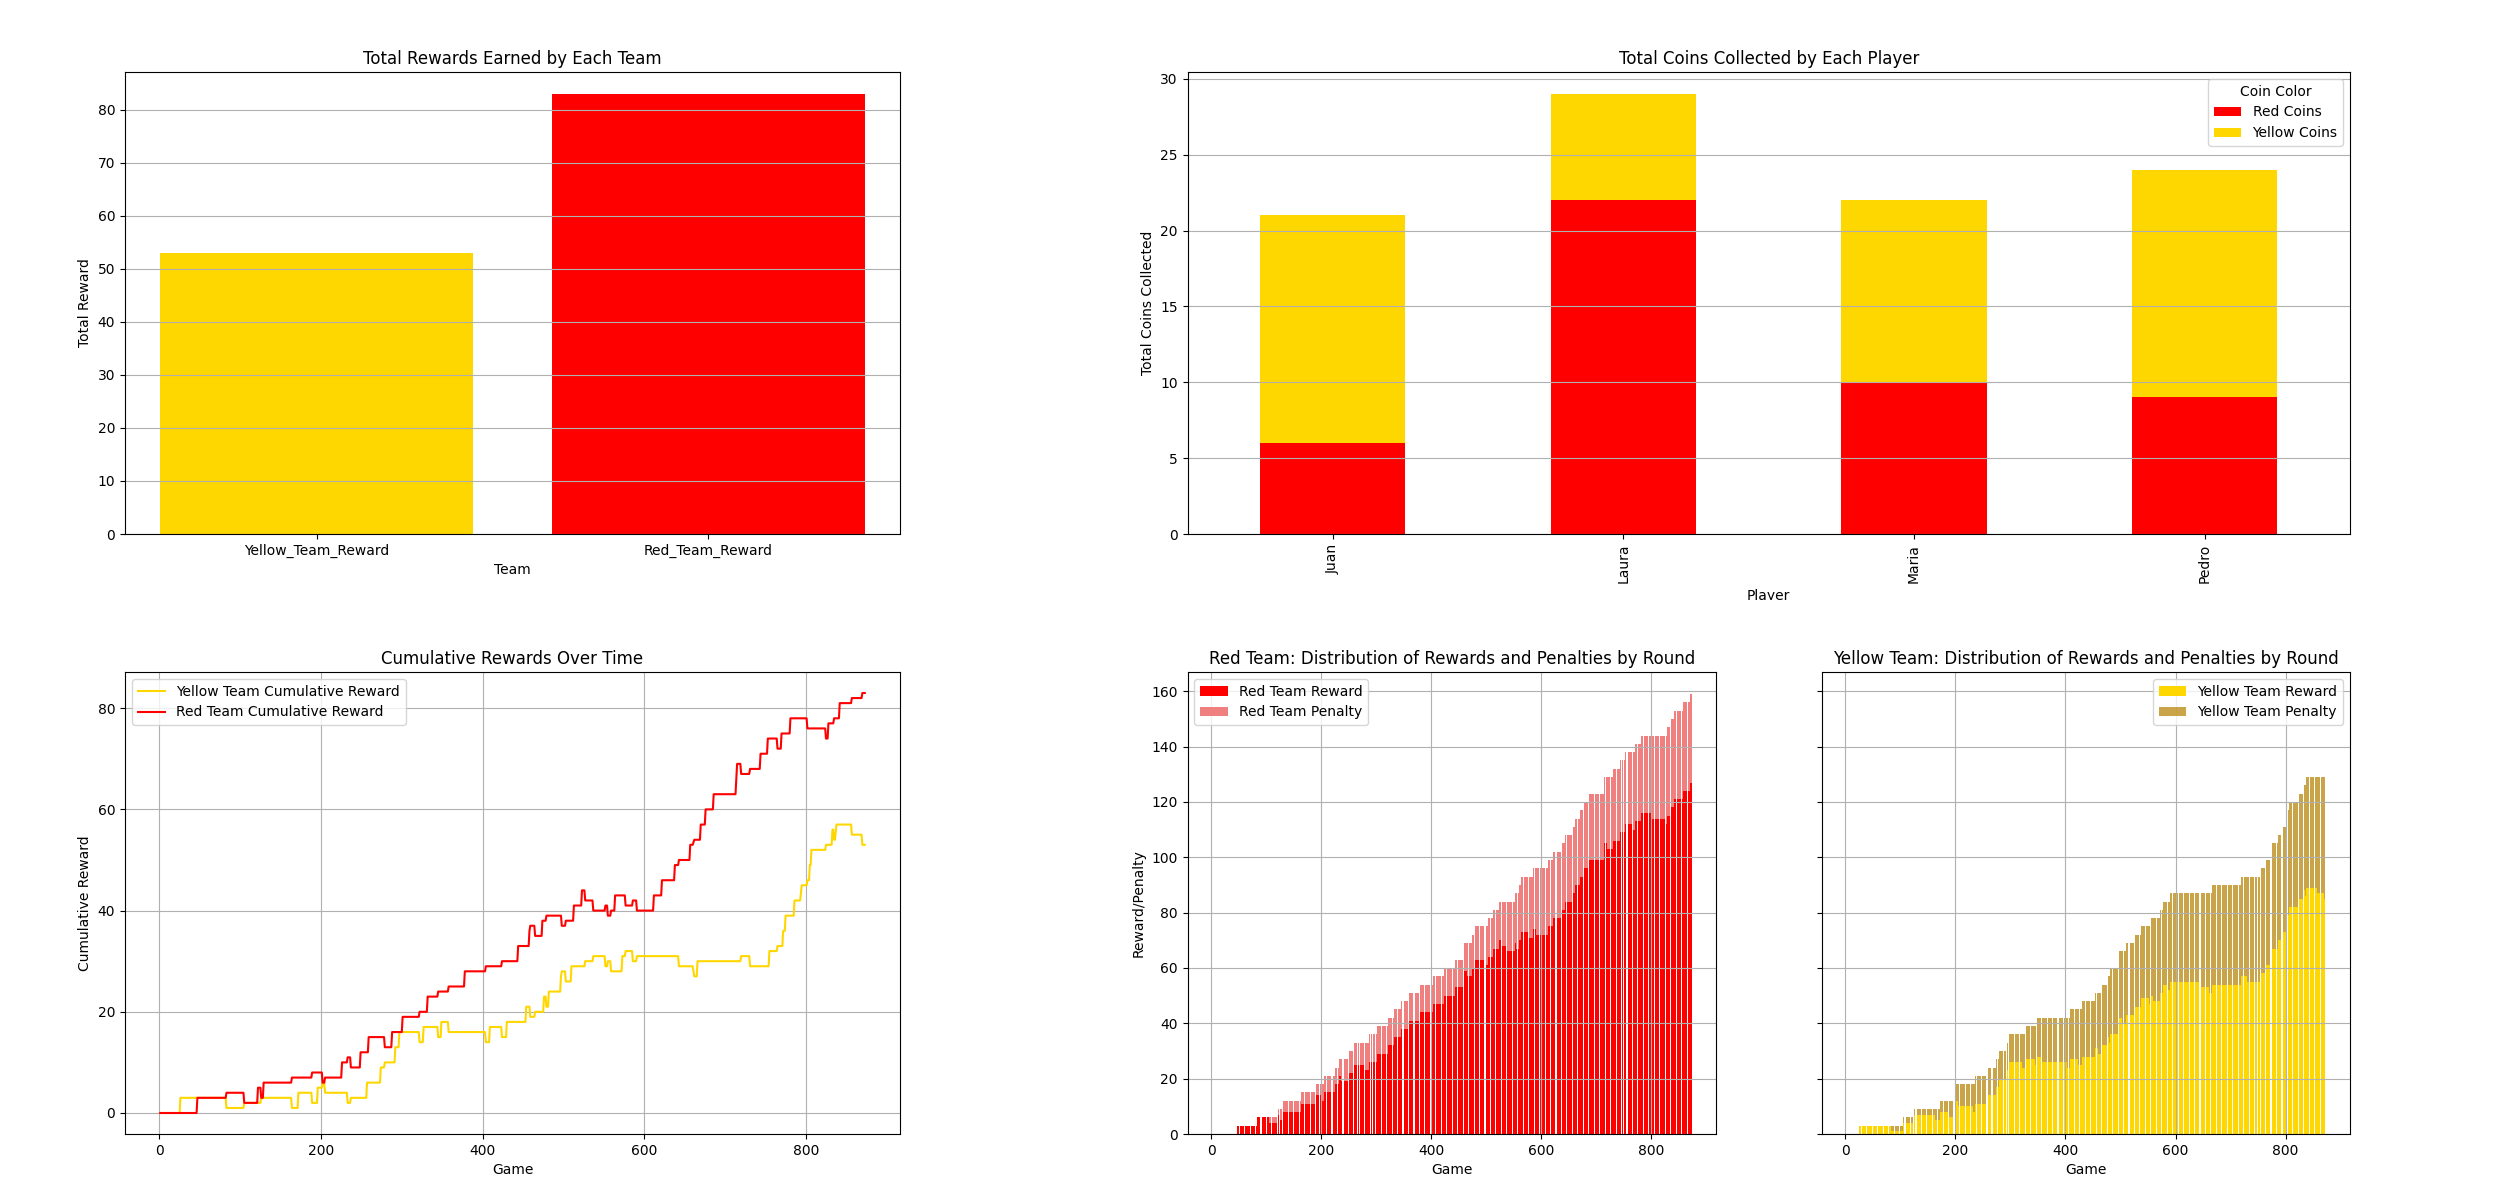

<Figure size 1200x600 with 0 Axes>

In [10]:
simulation_folder1 = LOGS_FOLDER + '2024-06-14--02-53-10'
create_dashboard_image(simulation_folder1, show=True)

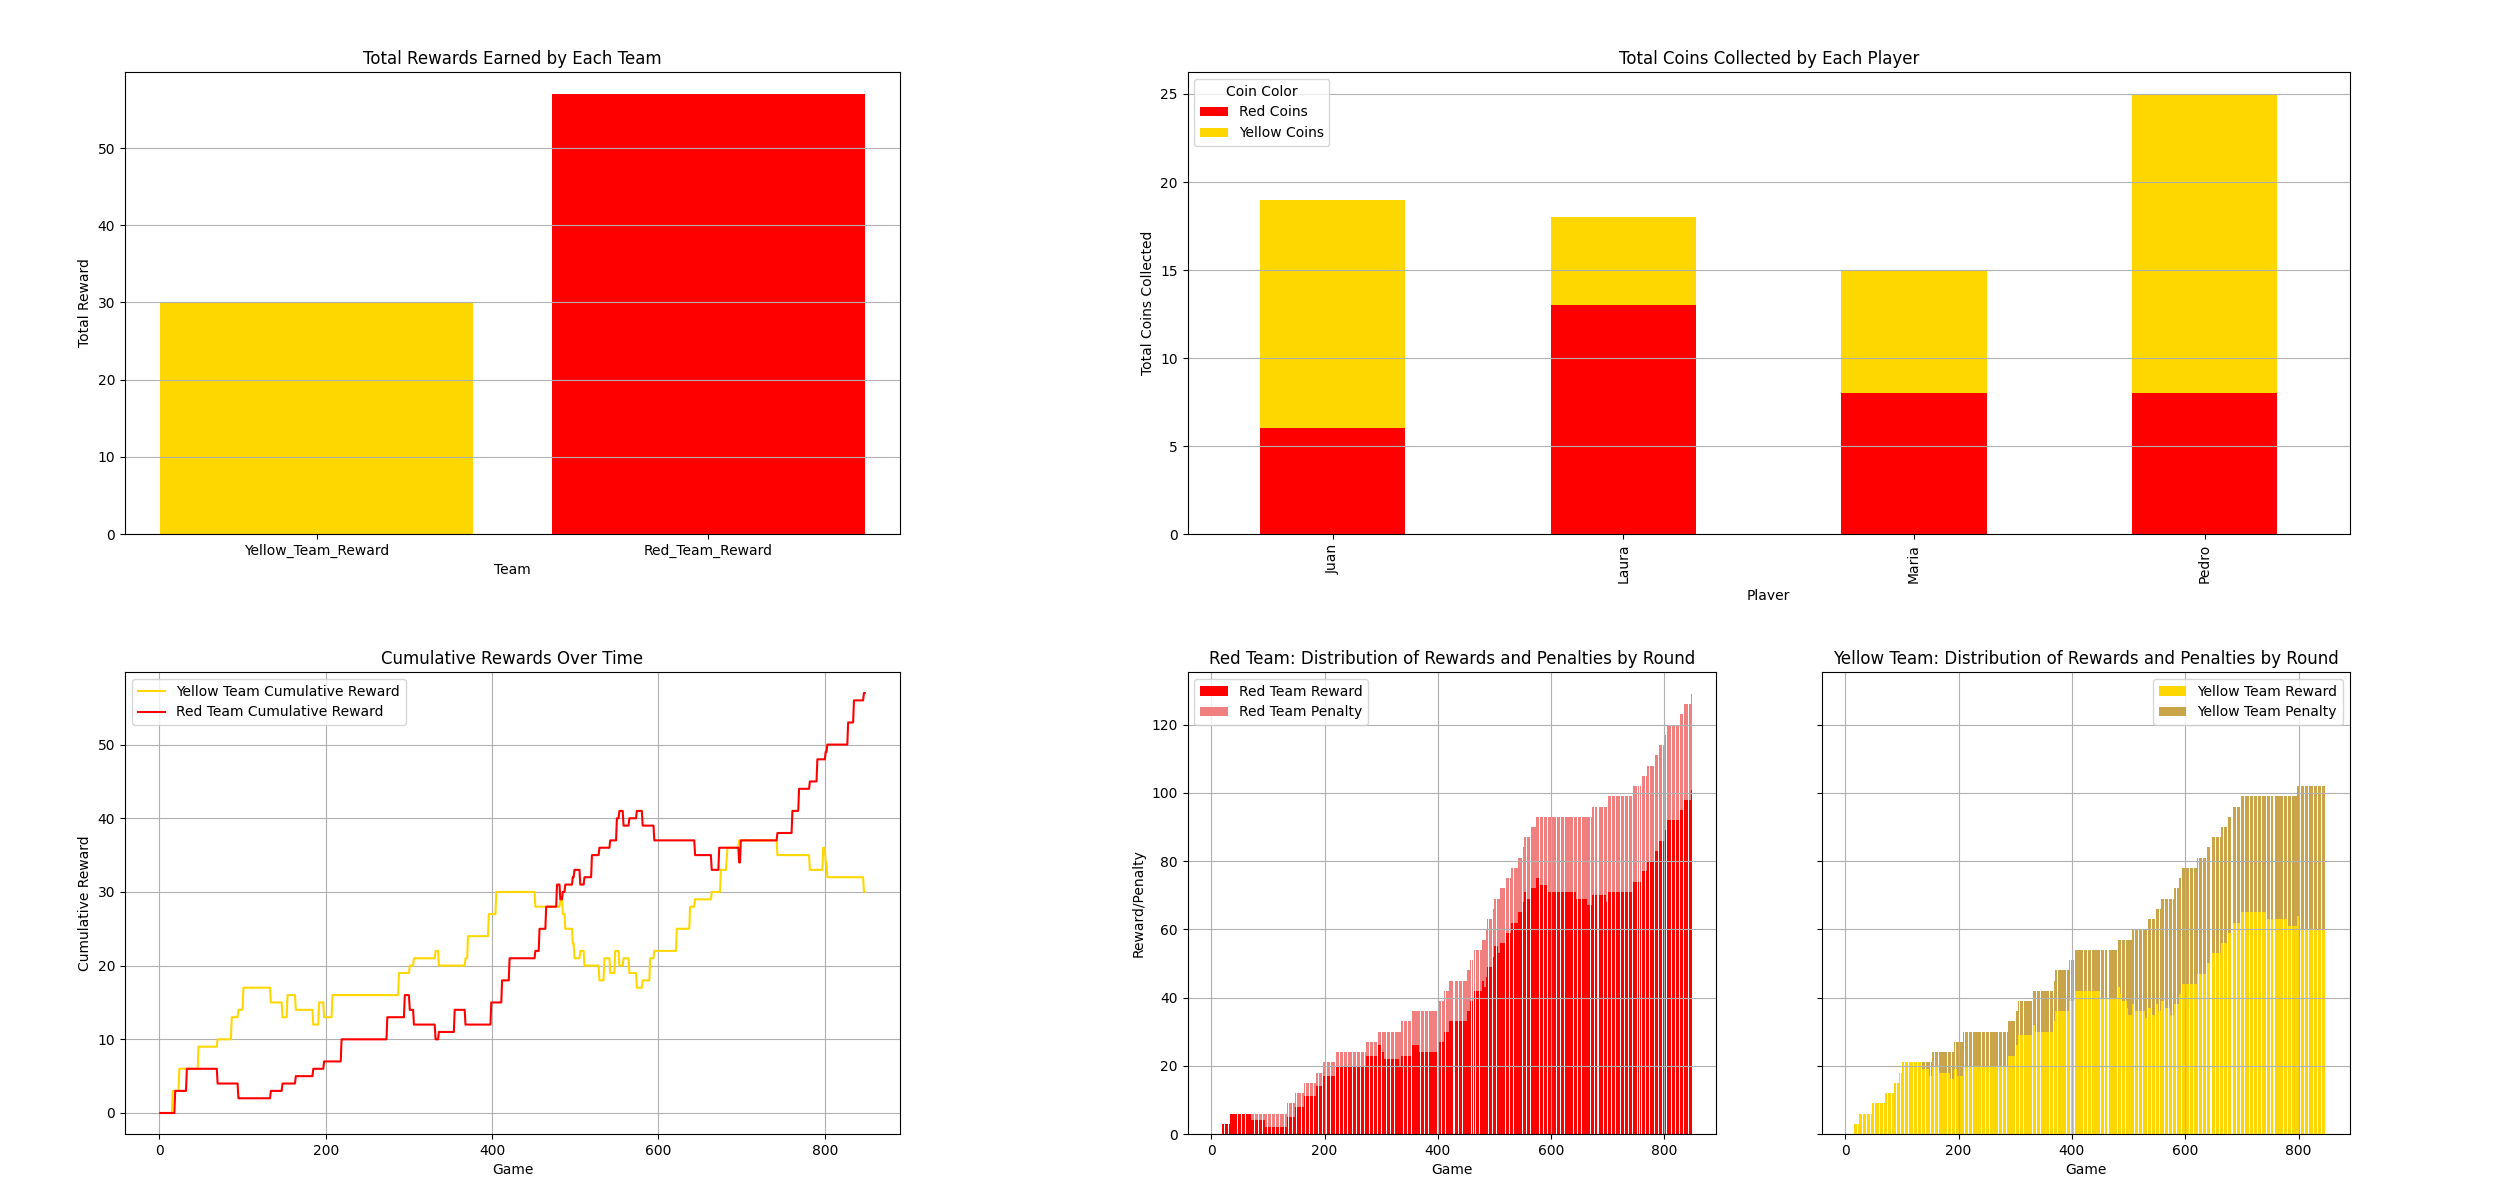

<Figure size 1200x600 with 0 Axes>

In [11]:
simulation_folder2 = LOGS_FOLDER + '2024-06-14--02-53-15'
create_dashboard_image(simulation_folder2, show=True)


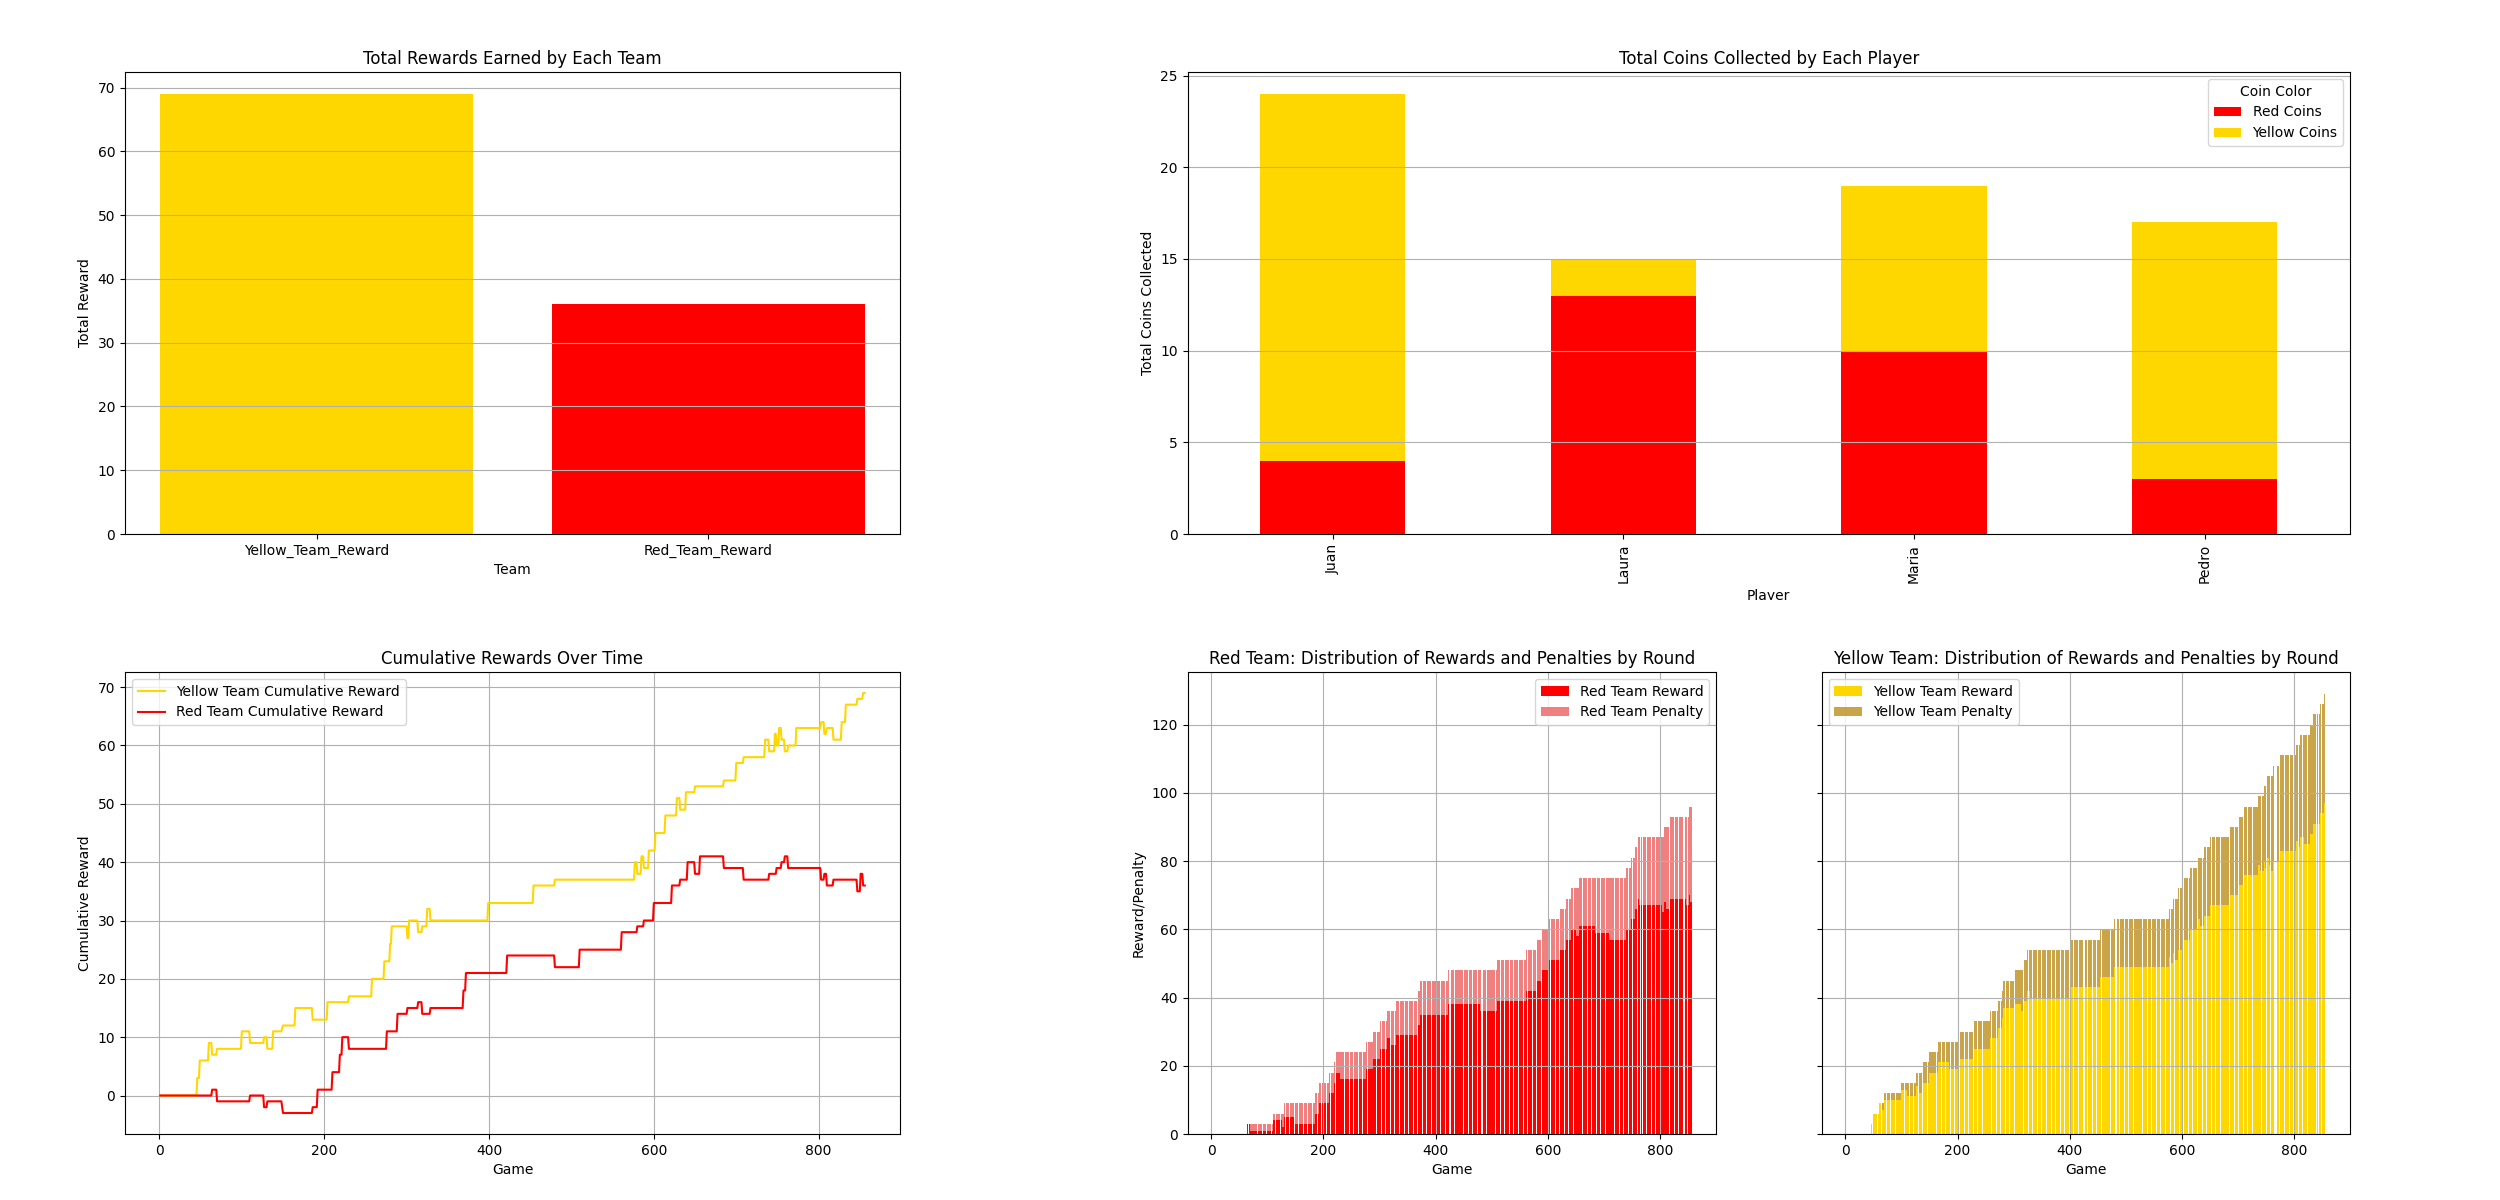

<Figure size 1200x600 with 0 Axes>

In [12]:
simulation_folder3 = LOGS_FOLDER + '2024-06-14--02-53-20'
create_dashboard_image(simulation_folder3, show=True)